In [1]:
import pandas as pd

from df_loader import PredDFLoader, CrisprDFLoader
from overlaps import compute_all_overlaps
from schema import DFSchema
import matplotlib.pyplot as plt
import numpy as np

In [2]:
CRISPR_FILENAME = "/oak/stanford/groups/engreitz/Projects/Benchmarking/CRISPR_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz"
DEV_FILENAME = "/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_K562_no_fit_dev/Predictions/EnhancerPredictionsAllPutative.txt.gz"
KRISTY_FILENAME = "/oak/stanford/groups/engreitz/Users/kmualim/02212022_hg38Preds_QNORM-hic/K562_ID_2644/Predictions/EnhancerPredictionsAllPutative.txt.gz"
TSS_REF_FILE = "resources/genome_annotations/RefSeqCurated.170308.bed.CollapsedGeneBounds.hg38.TSS500bp.bed"
ABC_THRESHOLD = 0.02


In [18]:
def pairs_in_common(df_a, df_b):
    id_fields = ["TargetGene", "name"]
    return pd.merge(df_a, df_b, on=id_fields, how='inner', suffixes=['_a', '_b'])

In [19]:
df_a = PredDFLoader(DEV_FILENAME, TSS_REF_FILE, ABC_THRESHOLD).load()
df_b = PredDFLoader(KRISTY_FILENAME, TSS_REF_FILE, ABC_THRESHOLD).load()
print(f"dev has {len(df_a)} lines. Kristy has {len(df_b)} lines")

/oak/stanford/groups/engreitz/Users/atan5133/anthonys_scripts/error_analysis/df_loader.py:11: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filename_tsv, delimiter="\t", compression="gzip")


dev has 9616080 lines. Kristy has 9598720 lines


In [20]:
def count_positives(df):
    return len(df[df["ABC.Score"] >= ABC_THRESHOLD])
print(f"Dev has {count_positives(df_a)} positives. Kristy has {count_positives(df_b)} positives.")

Dev has 114122 positives. Kristy has 107632 positives.


In [21]:
common = pairs_in_common(df_a, df_b)
print(f"{len(common)} lines in common")



9568501 lines in common


In [22]:
score_difference = abs(common['ABC.Score_a'] - common['ABC.Score_b'])
common["score_difference"] = score_difference
# 1 million differences
significant_diff = .001

total_differences = common[score_difference > 0]
print(f"{len(total_differences)} total differences")

significant_differences = common[score_difference > significant_diff]
print(f"{len(significant_differences)} significant differences")


9490977 total differences
372955 significant differences


Text(0.5, 1.0, 'Histogram of Score Differences')

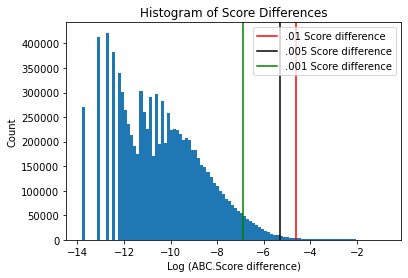

In [28]:
differences = score_difference[score_difference > 0]

plt.hist(np.log(differences), bins=100) 
plt.axvline(x=np.log(.01), color='red', linestyle='solid', label=".01 Score difference")
plt.axvline(x=np.log(.005), color='black', linestyle='solid', label=".005 Score difference")
plt.axvline(x=np.log(.001), color='green', linestyle='solid', label=".001 Score difference")
plt.xlabel('Log (ABC.Score difference)')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram of Score Differences')

In [24]:
def print_threshold_summary(threshold, num_differences, total_entries):
    pct = round((num_differences / total_entries) * 100, 3)
    print(f"There are {num_differences}/{total_entries} of {threshold} or larger differences. Equal to {pct}%")

print_threshold_summary(.02, len(common[score_difference > .02]), len(common))
print_threshold_summary(.01, len(common[score_difference > .01]), len(common))
print_threshold_summary(.005, len(common[score_difference > .005]), len(common))
print_threshold_summary(.001, len(common[score_difference > .001]), len(common))

There are 20030/9568501 of 0.02 or larger differences. Equal to 0.209%
There are 32810/9568501 of 0.01 or larger differences. Equal to 0.343%
There are 59715/9568501 of 0.005 or larger differences. Equal to 0.624%
There are 372955/9568501 of 0.001 or larger differences. Equal to 3.898%


In [25]:
dev_pos_kristy_neg = common[(common['ABC.Score_a'] >= ABC_THRESHOLD) & (common['ABC.Score_b'] < ABC_THRESHOLD)]
dev_neg_kristy_pos = common[(common['ABC.Score_a'] < ABC_THRESHOLD) & (common['ABC.Score_b'] >= ABC_THRESHOLD)]

In [26]:
print(f"{len(dev_pos_kristy_neg)} dev_pos_kristy_neg. {len(dev_neg_kristy_pos)} dev_neg_kristy_pos")


9325 dev_pos_kristy_neg. 3629 dev_neg_kristy_pos


In [29]:
pd.set_option('display.max_rows', 100)
dev_pos_kristy_neg.iloc[0]

index_a                                                             5486
chrom_a                                                            chr17
start_a                                                          1321997
end_a                                                            1322497
name                                    intergenic|chr17:1321997-1322497
class_a                                                       intergenic
activity_base_a                                                 5.875652
normalized_dhs_a                                                7.728392
activity_base_squared_a                                        34.523286
TargetGene                                                         YWHAE
TargetGeneTSS_a                                                  1400012
TargetGeneExpression_a                                               NaN
TargetGenePromoterActivityQuantile_a                            0.743774
TargetGeneIsExpressed_a                            